## Late night sports analysis

*Problem:*
A regional sports network is currently paying editors and analysts overtime after each game to produce same-day video analysis for their web properties. This overtime is costly and while some videos do gain lots of views, others do not.

What factors influence the popularity of these videos produced and published immediately after games? Importantly, can some of the analysis wait until the next morning?

*Target Variable:*
Editorial Video Plays reported in Google Analytics for game related content posted after the game played between the end of the game and the next morning.

*Benefit:*
If we could predict the value of producing this video in terms of plays that same night, we could recommend for or against paying analysts overtime versus finishing the work in the morning.

*Features:*
We would want to consider at least:
- wins versus losses,
- the record of the teams entering the game,
- if the game went to an overtime,
- the score of the game,
- the category of the video,
- home v. away games,
- the date of the game.

*Goals:*
We aim to hold video plays steady while reducing overtime costs.

*Risks and limitations:*
It is not clear that these factors correlate with a difference in videos plays for same-day game related content. We will also need to use multiple data sets in order to add all of these factors. FiveThirtyEight Elo score would have been a great addition, but their dataset contains no data for this year.

There may also be a risk that other factors like individual player records being broken, in-game fights or off-court storylines play a large role in the popularity of videos. However, this system will be a tool for a more data-informed decision at the end of games and human decision making can take these factors into account.

[Presentation with analysis here](https://docs.google.com/presentation/d/1ZKu0WyndVnQe9JiDRV3fNX9tPtGDxLLYX22xUqa08j8/edit?usp=sharing)

## Begin by importing useful packages

In [1]:
#Import, Manage and Explore Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

#Models and Evaluation
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import PolynomialFeatures

## Read in data

In [2]:
#Google Analytics data pulled using SuperMetrics and exported as a .csv
videos = pd.read_csv('./data/Knicks_Videos_2.csv')
print(videos.head())

#Data about individual games from Basketball Reference .com
Games_Data = pd.read_csv('./data/Knicks_Results.csv')
Games_Data

#Data about the quality of opponents from FiveThirtyEight
Opponent_Elo = pd.read_csv('./data/MSGN_Carmello_Elo.csv')
Opponent_Elo.head()

         Date  Hour  Custom dimension 2  Custom dimension 10  \
0  2018-10-17     0       5848208685001       Highlight Clip   
1  2018-10-17     0       5848212795001    Highlight Package   
2  2018-10-17     0       5848245394001  Highlights Analysis   
3  2018-10-17     1       5848217072001       Highlight Clip   
4  2018-10-17     1       5848219492001  Highlights Analysis   

                       Custom dimension 5         Custom dimension 3  \
0  Al Trautwig,Alan Hahn,Wally Szczerbiak  Knicks vs Nets 2018-10-12   
1  Al Trautwig,Alan Hahn,Wally Szczerbiak  Knicks vs Nets 2018-10-12   
2  Al Trautwig,Alan Hahn,Wally Szczerbiak  Knicks at Nets 2018-10-03   
3              Alan Hahn,Wally Szczerbiak  Knicks vs Nets 2018-10-12   
4              Alan Hahn,Wally Szczerbiak  Knicks vs Nets 2018-10-12   

   Total events  
0             1  
1             1  
2             1  
3             1  
4             1  


,Elo,Team,Record,Playoffs,Finals,Champion
0,1802,Warriors,61-21,>99%,74%,61%
1,1696,Thunder,53-29,>99%,13%,8%
2,1690,Raptors,59-23,>99%,37%,12%
3,1678,Rockets,50-32,99%,6%,3%
4,1672,Celtics,53-29,>99%,20%,4%


In [3]:
print('dtypes \n\n', videos.dtypes, '\n')
print('shape \n\n', videos.shape, '\n')
print('null values \n\n', videos.isnull().sum())

dtypes 

 Date                   object
Hour                    int64
Custom dimension 2      int64
Custom dimension 10    object
Custom dimension 5     object
Custom dimension 3     object
Total events            int64
dtype: object 

shape 

 (12903, 7) 

null values 

 Date                   0
Hour                   0
Custom dimension 2     0
Custom dimension 10    0
Custom dimension 5     0
Custom dimension 3     0
Total events           0
dtype: int64


## Transform data into a useful dataset

We have three dataframes now and each needs some clean-up. Then we need to pull them into one useful dataframe for analysis

In [4]:
#Add descriptive column names
videos.columns = ['Play_Date', 'Hour', 'Video_ID', 'Category', 'Personalities', 'Game_Tax', 'Video_Plays']

videos.head()

,Play_Date,Hour,Video_ID,Category,Personalities,Game_Tax,Video_Plays
0,2018-10-17,0,5848208685001,Highlight Clip,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1
1,2018-10-17,0,5848212795001,Highlight Package,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1
2,2018-10-17,0,5848245394001,Highlights Analysis,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks at Nets 2018-10-03,1
3,2018-10-17,1,5848217072001,Highlight Clip,"Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1
4,2018-10-17,1,5848219492001,Highlights Analysis,"Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1


In [5]:
#Turn feature-rich "Game Taxonomy" into more granular "Game_Date" and "Opponent"
videos.loc[:, 'Game_Date'] = videos.loc[:, 'Game_Tax'].str.slice(-10,)
videos.loc[:, 'Game_Detail'] = videos.loc[:, 'Game_Tax'].str.slice(0,-11)
videos.loc[:, 'Opponent'] = videos.loc[:, 'Game_Detail'].str.slice(9,)

videos.head()

,Play_Date,Hour,Video_ID,Category,Personalities,Game_Tax,Video_Plays,Game_Date,Game_Detail,Opponent
0,2018-10-17,0,5848208685001,Highlight Clip,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1,2018-10-12,Knicks vs Nets,Nets
1,2018-10-17,0,5848212795001,Highlight Package,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1,2018-10-12,Knicks vs Nets,Nets
2,2018-10-17,0,5848245394001,Highlights Analysis,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks at Nets 2018-10-03,1,2018-10-03,Knicks at Nets,Nets
3,2018-10-17,1,5848217072001,Highlight Clip,"Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1,2018-10-12,Knicks vs Nets,Nets
4,2018-10-17,1,5848219492001,Highlights Analysis,"Alan Hahn,Wally Szczerbiak",Knicks vs Nets 2018-10-12,1,2018-10-12,Knicks vs Nets,Nets


In [6]:
#Transform to datetime
videos.loc[:, 'Play_Date'] = pd.to_datetime(videos.loc[:, 'Play_Date'])
videos.loc[:, 'Game_Date'] = pd.to_datetime(videos.loc[:, 'Game_Date'])

videos.dtypes

Play_Date        datetime64[ns]
Hour                      int64
Video_ID                  int64
Category                 object
Personalities            object
Game_Tax                 object
Video_Plays               int64
Game_Date        datetime64[ns]
Game_Detail              object
Opponent                 object
dtype: object

### Target Variable

One important transformation is to nail down the target variable. In this case we are looking for the number of times users watched postgame content the night of the game.

In [7]:
#Our target variable is actually not just video plays the night of the game, but that night and the next morning up uptil 9am
videos.loc[:, 'Day_After_Game'] = videos.loc[:, 'Game_Date'] + pd.DateOffset(1)

Target_Video_Plays = videos.loc[((
    videos.loc[:, 'Play_Date'] == videos.loc[:, 'Day_After_Game']) & (
    videos.loc[:, 'Hour'] < 9)) | (
    videos.loc[:, 'Play_Date'] == videos.loc[:, 'Game_Date']), :]
print(Target_Video_Plays.shape)
print(Target_Video_Plays.head())

(5287, 11)
    Play_Date  Hour       Video_ID             Category  \
38 2018-10-17    22  5844106048001       Highlight Clip   
39 2018-10-17    22  5844106048001       Highlight Clip   
43 2018-10-17    22  5848516112001     Player Interview   
44 2018-10-17    22  5848522853001     Player Interview   
45 2018-10-17    22  5848694765001  Highlights Analysis   

                             Personalities                    Game_Tax  \
38  Al Trautwig,Alan Hahn,Wally Szczerbiak  Knicks vs Hawks 2018-10-17   
39                         Rebecca Haarlow  Knicks vs Hawks 2018-10-17   
43                         Rebecca Haarlow  Knicks vs Hawks 2018-10-17   
44                         Rebecca Haarlow  Knicks vs Hawks 2018-10-17   
45  Al Trautwig,Alan Hahn,Wally Szczerbiak  Knicks vs Hawks 2018-10-17   

    Video_Plays  Game_Date      Game_Detail Opponent Day_After_Game  
38            2 2018-10-17  Knicks vs Hawks    Hawks     2018-10-18  
39            2 2018-10-17  Knicks vs Hawks    Ha

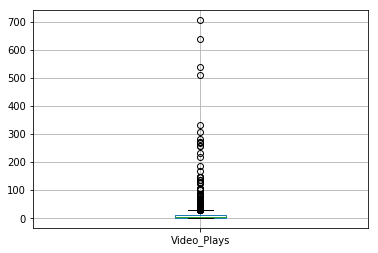

In [8]:
#Sum by unique video and take a look at the distribution
Video_ID_Sum = Target_Video_Plays.groupby('Video_ID')['Video_Plays'].sum()

Video_ID_Sum = Video_ID_Sum.to_frame()

Video_ID_Sum.boxplot();

In [9]:
#Add Game data and Elo--a measure of the quality of the opponent
Opponent_Elo.columns = ['Elo', 'Opponent', 'Opponent_Record', 'Playoffs', 'Finals', 'Champion']
Game_Data_Elo = pd.merge(Games_Data, Opponent_Elo)

Game_Data_Elo.head()

,Game_Index,Date,Start_Time,Away_Old,Away,Opponent,Win_Loss,Loss,Loss_n-1,Overtime,...,Total_Wins,Total_Loss,Record_Net,Streak,Streak_Clean,Elo,Opponent_Record,Playoffs,Finals,Champion
0,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,1,0,1,W 1,1,1340,27-55,<1%,<1%,<1%
1,12,Wed Nov 7 2018,7:30p,@,1,Hawks,W,0,1,0,...,4,8,-4,W 1,1,1340,27-55,<1%,<1%,<1%
2,34,Fri Dec 21 2018,7:30p,NaN,0,Hawks,L,1,1,0,...,9,25,-16,L 4,-4,1340,27-55,<1%,<1%,<1%
3,2,Fri Oct 19 2018,7:30p,@,1,Nets,L,1,0,0,...,1,1,0,L 1,-1,1466,39-43,83%,<1%,<1%
4,7,Mon Oct 29 2018,7:30p,NaN,0,Nets,W,0,1,0,...,2,5,-3,W 1,1,1466,39-43,83%,<1%,<1%


In [10]:
#Create Game Date column and merge with our videos dataset
Game_Data_Elo.loc[:, 'Game_Date'] = pd.to_datetime(Game_Data_Elo.loc[:, 'Date'], format='%a %b %d %Y')

Full_Game_Video = pd.merge(Game_Data_Elo, Target_Video_Plays, on='Game_Date')

Full_Game_Video.head()

,Game_Index,Date,Start_Time,Away_Old,Away,Opponent_x,Win_Loss,Loss,Loss_n-1,Overtime,...,Play_Date,Hour,Video_ID,Category,Personalities,Game_Tax,Video_Plays,Game_Detail,Opponent_y,Day_After_Game
0,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,2018-10-17,22,5844106048001,Highlight Clip,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Hawks 2018-10-17,2,Knicks vs Hawks,Hawks,2018-10-18
1,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,2018-10-17,22,5844106048001,Highlight Clip,Rebecca Haarlow,Knicks vs Hawks 2018-10-17,2,Knicks vs Hawks,Hawks,2018-10-18
2,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,2018-10-17,22,5848516112001,Player Interview,Rebecca Haarlow,Knicks vs Hawks 2018-10-17,1,Knicks vs Hawks,Hawks,2018-10-18
3,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,2018-10-17,22,5848522853001,Player Interview,Rebecca Haarlow,Knicks vs Hawks 2018-10-17,1,Knicks vs Hawks,Hawks,2018-10-18
4,1,Wed Oct 17 2018,7:30p,NaN,0,Hawks,W,0,0,0,...,2018-10-17,22,5848694765001,Highlights Analysis,"Al Trautwig,Alan Hahn,Wally Szczerbiak",Knicks vs Hawks 2018-10-17,2,Knicks vs Hawks,Hawks,2018-10-18


In [11]:
#Start Time would be better as just an integer for hours
Full_Game_Video.loc[:, 'Start_Time'] = Full_Game_Video.loc[:, 'Start_Time'].str.split(':').str[0]

In [12]:
#A quick check of our work
print('dtypes \n\n', Full_Game_Video.dtypes, '\n')
print('shape \n\n', Full_Game_Video.shape, '\n')
print('null values \n\n', Full_Game_Video.isnull().sum())

dtypes 

 Game_Index                  int64
Date                       object
Start_Time                 object
Away_Old                   object
Away                        int64
Opponent_x                 object
Win_Loss                   object
Loss                        int64
Loss_n-1                    int64
Overtime                    int64
Tm_Score                    int64
Opp_Score                   int64
Score_Net                   int64
Total_Wins                  int64
Total_Loss                  int64
Record_Net                  int64
Streak                     object
Streak_Clean                int64
Elo                         int64
Opponent_Record            object
Playoffs                   object
Finals                     object
Champion                   object
Game_Date          datetime64[ns]
Play_Date          datetime64[ns]
Hour                        int64
Video_ID                    int64
Category                   object
Personalities              object
Game

In [13]:
#Lets get rid of the Away_Old Column, and while we're at it, Win_Loss, Streak, Playoffs, Finals, Champion also
#Importantly, Hour and Play_Date and others have played their part in filtering the data down,
#but now we want to combine rows so we get one row for each video. Let's drop those now.

#Running some analysis, we learn that much of the Google Analytics data is tainted becauase GA was pulling up Personality,
#Category and other data from the page on which the video played rather than the video itself.
#These might be valuable if our model needs to decrease bias in the future,
#but we would need to get an index of the real data for these from the Video Player (Brightcove). For now we will drop those columns.
Full_Game_Video.drop(['Away_Old', 
                      'Win_Loss', 
                      'Streak', 
                      'Playoffs', 
                      'Finals', 
                      'Champion', 
                      'Hour', 
                      'Play_Date', 
                      'Date', 
                      'Opponent_y', 
                      'Game_Tax', 
                      'Game_Detail', 
                      'Day_After_Game',
                      'Category',
                      'Personalities'], axis='columns', inplace=True)

Full_Game_Video.columns

Index(['Game_Index', 'Start_Time', 'Away', 'Opponent_x', 'Loss', 'Loss_n-1',
       'Overtime', 'Tm_Score', 'Opp_Score', 'Score_Net', 'Total_Wins',
       'Total_Loss', 'Record_Net', 'Streak_Clean', 'Elo', 'Opponent_Record',
       'Game_Date', 'Video_ID', 'Video_Plays'],
      dtype='object')

In [14]:
#Let's also aggregate by video ID so each row shows the total plays that each unique video received during our window
Video_ID_Sum = Full_Game_Video.groupby('Video_ID')['Video_Plays'].sum().to_frame()

Total_Plays_Clean = pd.merge(Full_Game_Video, Video_ID_Sum, on='Video_ID')

Total_Plays_Clean.head()

,Game_Index,Start_Time,Away,Opponent_x,Loss,Loss_n-1,Overtime,Tm_Score,Opp_Score,Score_Net,Total_Wins,Total_Loss,Record_Net,Streak_Clean,Elo,Opponent_Record,Game_Date,Video_ID,Video_Plays_x,Video_Plays_y
0,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,2,148
1,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,2,148
2,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,1,148
3,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,21,148
4,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,1,148


In [15]:
#Let's rename our coulumns again
Trimmed_Total_Plays = Total_Plays_Clean.drop('Video_Plays_x', axis='columns')

Trimmed_Total_Plays.columns = ['Game_Index', 'Start_Time', 'Away', 'Opponent', 'Loss', 'Loss_n-1',
       'Overtime', 'Tm_Score', 'Opp_Score', 'Score_Net', 'Total_Wins',
       'Total_Loss', 'Record_Net', 'Streak_Clean', 'Elo', 'Opponent_Record',
       'Game_Date', 'Video_ID', 'Video_Plays_Total']

Trimmed_Total_Plays.head()

,Game_Index,Start_Time,Away,Opponent,Loss,Loss_n-1,Overtime,Tm_Score,Opp_Score,Score_Net,Total_Wins,Total_Loss,Record_Net,Streak_Clean,Elo,Opponent_Record,Game_Date,Video_ID,Video_Plays_Total
0,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,148
1,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,148
2,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,148
3,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,148
4,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,5844106048001,148


In [16]:
#There are a bunch of duplicate rows now that we've gotten rid of some tainted features. Time to get rid of those as well.
Trimmed_Total_Plays.sort_values('Video_ID', inplace=True)
Trimmed_Total_Plays.loc[:, 'Duplicate'] = Trimmed_Total_Plays.duplicated(subset='Video_ID', keep='first')
Trimmed_Total_Plays = Trimmed_Total_Plays.loc[Trimmed_Total_Plays.loc[:, 'Duplicate'] == False, :]

Trimmed_Total_Plays.head()

,Game_Index,Start_Time,Away,Opponent,Loss,Loss_n-1,Overtime,Tm_Score,Opp_Score,Score_Net,Total_Wins,Total_Loss,Record_Net,Streak_Clean,Elo,Opponent_Record,Game_Date,Video_ID,Video_Plays_Total,Duplicate
1696,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,5450217995001,1,False
1697,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,5450266286001,1,False
1668,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,5450279763001,1,False
1669,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,5450376272001,1,False
1670,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,5450391556001,1,False


In [17]:
#A quick check of our work
print('dtypes \n\n', Trimmed_Total_Plays.dtypes, '\n')
print('shape \n\n', Trimmed_Total_Plays.shape, '\n')
print('null values \n\n', Trimmed_Total_Plays.isnull().sum())

dtypes 

 Game_Index                    int64
Start_Time                   object
Away                          int64
Opponent                     object
Loss                          int64
Loss_n-1                      int64
Overtime                      int64
Tm_Score                      int64
Opp_Score                     int64
Score_Net                     int64
Total_Wins                    int64
Total_Loss                    int64
Record_Net                    int64
Streak_Clean                  int64
Elo                           int64
Opponent_Record              object
Game_Date            datetime64[ns]
Video_ID                      int64
Video_Plays_Total             int64
Duplicate                      bool
dtype: object 

shape 

 (769, 20) 

null values 

 Game_Index           0
Start_Time           0
Away                 0
Opponent             0
Loss                 0
Loss_n-1             0
Overtime             0
Tm_Score             0
Opp_Score            0
Score_Net  

## Explore the data

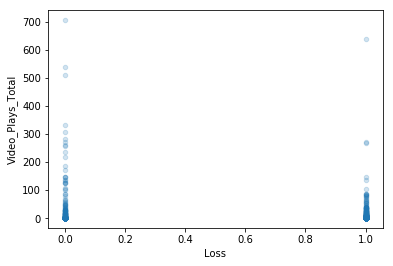

In [18]:
Trimmed_Total_Plays.plot(kind='Scatter', x='Loss', y='Video_Plays_Total', alpha=.2);

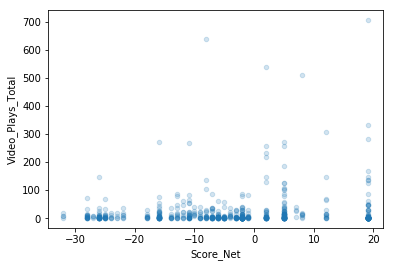

In [59]:
Trimmed_Total_Plays.plot(kind='Scatter', x='Score_Net', y='Video_Plays_Total', alpha=.2);

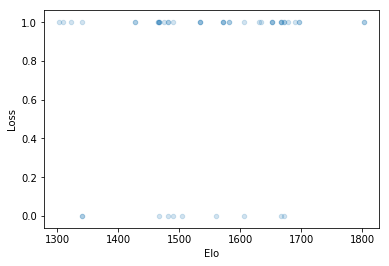

In [20]:
Game_Data_Elo.plot(kind='Scatter', x='Elo', y='Loss', alpha=.2);

C:\Users\mail\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


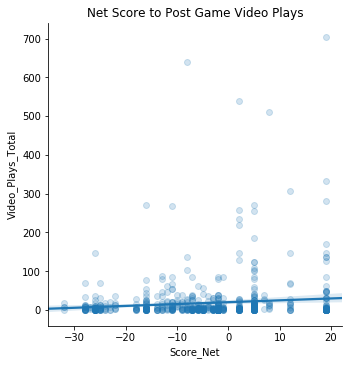

In [65]:
g = sns.lmplot(x='Score_Net',
               y='Video_Plays_Total',
               data=Trimmed_Total_Plays,
               scatter_kws={'alpha':0.2}
               );
g.ax.set_title('Net Score to Post Game Video Plays');

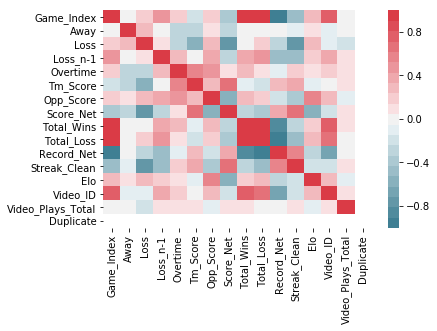

In [22]:
sns.heatmap(Trimmed_Total_Plays.corr(),
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            );

## Models

### Linear Regression

Let's fit some linear regression and see if it can beat a null model

In [23]:
lr = LinearRegression()

feature_cols = ['Score_Net']

X = Trimmed_Total_Plays.loc[:, feature_cols]
y = Trimmed_Total_Plays.loc[:, 'Video_Plays_Total']

lr.fit(X, y)

print(lr.intercept_)
print(lr.coef_)

20.266404961080376
[0.48080334]


In [24]:
lr_2 = LinearRegression()

feature_cols = ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo']

X = Trimmed_Total_Plays.loc[:, feature_cols]
y = Trimmed_Total_Plays.loc[:, 'Video_Plays_Total']

lr_2.fit(X, y)

print(lr_2.intercept_)
print(lr_2.coef_)

50.334902183378325
[ 0.14208062 -4.06075485 -2.66441486 15.06150513 -0.84900783  3.47019838
 -0.0245451 ]


In [25]:
#Create that null predition and see what the Root Mean Square Error is--hoping that we beat it with our regression
null_pred = np.zeros(y.shape)
null_pred += np.mean(y)

null_rmse = np.sqrt(metrics.mean_squared_error(null_pred, y))
null_rmse

56.824854013401776

So we did beat our null prediction, but really not by much. I tried a few methods to improve the prediction. Let's take a quick look at one--adding polynomial features. Unfortunately, it didn't help that much. Another example is including and excluding certain features. Again, not a huge lift--but notworthy that "Game Index" was a hit. This data is a timeseries afterall. We definitely want to include it in further models.

In [26]:
kf = KFold(n_splits=5, shuffle=True)

for poly_degree in range(1, 11):
    pf = PolynomialFeatures(degree=poly_degree, include_bias=False)
    X_poly = pf.fit_transform(X)
    lr = LinearRegression()
    score = -cross_val_score(lr, X_poly, y, cv=kf, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(score)
    rmse = np.mean(rmse_scores)
    print(poly_degree, rmse)

1 54.99024474063077
2 52.42922533971438
3 56.16041401490527
4 62.9116785192842
5 67.85386062131658
6 54.30629569838036
7 55.29764159068536
8 55.243327064476304
9 54.31686866383851
10 54.58258647900991


In [27]:
def train_test_MSGN(df, feature_cols):
    X = Trimmed_Total_Plays.loc[:, feature_cols]
    y = Trimmed_Total_Plays.loc[:, 'Video_Plays_Total']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    lr_2.fit(X_train, y_train)
    
    y_pred = lr_2.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(train_test_MSGN(Full_Game_Video, ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo', 'Game_Index']))
print(train_test_MSGN(Full_Game_Video, ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo']))
print(train_test_MSGN(Full_Game_Video, ['Score_Net', 'Loss', 'Overtime', 'Record_Net', 'Streak_Clean']))
print(train_test_MSGN(Full_Game_Video, ['Score_Net', 'Loss', 'Overtime']))

49.28093771027521
72.06710296441236
70.43210409640402
36.96907797576992


## Random Forest Regression

After some analysis and sluething, random forests seem a better option for our model primarily becauase:
1. Many of these features are 1 / 0 where a split is easy to make
2. Many of our features are related in tough to describe ways. For example, a higher quality opponent makes a loss more likely

In [28]:
feature_cols = ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo']

X = Trimmed_Total_Plays.loc[:, feature_cols]
y = Trimmed_Total_Plays.loc[:, 'Video_Plays_Total']

rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True)

rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True,
           random_state=None, verbose=0, warm_start=False)

In [29]:
pd.DataFrame(
    {'feature': feature_cols, 'importance': rfreg.feature_importances_}
).sort_values('importance', ascending=False)

,feature,importance
4,Record_Net,0.381125
0,Score_Net,0.195422
6,Elo,0.152659
2,Overtime,0.098642
5,Streak_Clean,0.089318
1,Loss,0.044169
3,Loss_n-1,0.038665


In [30]:
rfreg.oob_score_

0.04363881594073826

In [31]:
kf = KFold(n_splits=10, shuffle=True)

scores = -cross_val_score(rfreg, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(scores)
rmse = np.mean(rmse_scores)
rmse

53.666436632237115

## A twist: Video Plays Per Game

This just isn't explaining much. It turns out that plays per post game video is very tough to nail--especially missing descriptive features like video category which were tainted data from Google Analytics.

However, there is another way! Remember that the frame of the problem is to decide if we should keep editors working overtime after __a game__ so that means that we can aggregate data per game and use that to make the editorial decision.

In the future we can generate better models on clean data to help editors decide what kinds of videos perform best in situations where we decide to pay those editors overtime.

In [32]:
Game_Total_Plays = Trimmed_Total_Plays.groupby('Game_Index')['Video_Plays_Total'].sum().to_frame()

Plays_By_Game = pd.merge(Trimmed_Total_Plays, Game_Total_Plays, on='Game_Index')

Plays_By_Game = Plays_By_Game.drop(['Video_Plays_Total_x', 'Video_ID'], axis='columns')

Plays_By_Game.loc[:, 'Duplicate'] = Plays_By_Game.duplicated(subset='Game_Index', keep='first')

Plays_By_Game.sort_values('Game_Index', inplace=True)

Plays_By_Game = Plays_By_Game.loc[Plays_By_Game.loc[:, 'Duplicate'] == False, :]

Plays_By_Game

,Game_Index,Start_Time,Away,Opponent,Loss,Loss_n-1,Overtime,Tm_Score,Opp_Score,Score_Net,Total_Wins,Total_Loss,Record_Net,Streak_Clean,Elo,Opponent_Record,Game_Date,Duplicate,Video_Plays_Total_y
88,1,7,0,Hawks,0,0,0,126,107,19,1,0,1,1,1340,27-55,2018-10-17,False,1614
0,2,7,1,Nets,1,0,0,105,107,-2,1,1,0,-1,1466,39-43,2018-10-19,False,541
163,3,7,0,Celtics,1,1,0,101,103,-2,1,2,-1,-2,1672,53-29,2018-10-20,False,95
172,4,8,1,Bucks,1,1,0,113,124,-11,1,3,-2,-3,1666,60-22,2018-10-22,False,249
238,5,7,1,Heat,1,1,0,87,110,-23,1,4,-3,-4,1465,36-46,2018-10-24,False,31
219,6,7,0,Warriors,1,1,0,100,128,-28,1,5,-4,-5,1802,61-21,2018-10-26,False,190
191,7,7,0,Nets,0,1,0,115,96,19,2,5,-3,1,1466,39-43,2018-10-29,False,1160
242,8,8,0,Pacers,1,0,0,101,107,-6,2,6,-4,-1,1572,47-35,2018-10-31,False,230
281,9,8,1,Mavericks,0,1,0,118,106,12,3,6,-3,1,1489,36-46,2018-11-02,False,696
296,10,6,1,Wizards,1,0,0,95,108,-13,3,7,-4,-1,1534,37-45,2018-11-04,False,312


In [33]:
#A quick check of our work
print('dtypes \n\n', Plays_By_Game.dtypes, '\n')
print('shape \n\n', Plays_By_Game.shape, '\n')
print('null values \n\n', Plays_By_Game.isnull().sum())

dtypes 

 Game_Index                      int64
Start_Time                     object
Away                            int64
Opponent                       object
Loss                            int64
Loss_n-1                        int64
Overtime                        int64
Tm_Score                        int64
Opp_Score                       int64
Score_Net                       int64
Total_Wins                      int64
Total_Loss                      int64
Record_Net                      int64
Streak_Clean                    int64
Elo                             int64
Opponent_Record                object
Game_Date              datetime64[ns]
Duplicate                        bool
Video_Plays_Total_y             int64
dtype: object 

shape 

 (46, 19) 

null values 

 Game_Index             0
Start_Time             0
Away                   0
Opponent               0
Loss                   0
Loss_n-1               0
Overtime               0
Tm_Score               0
Opp_Score        

## Back to the Models, but with new data

In [34]:
#New null predictions and Root Mean Squared Error
y = Plays_By_Game.loc[:, 'Video_Plays_Total_y']

null_pred = np.zeros(y.shape)
null_pred += np.mean(y)

null_rmse = np.sqrt(metrics.mean_squared_error(null_pred, y))
null_rmse

381.09807332677997

In [38]:
#New Linear Regression
lr_3 = LinearRegression()

def train_test_MSGN_2(df, feature_cols):
    X = Plays_By_Game.loc[:, feature_cols]
    y = Plays_By_Game.loc[:, 'Video_Plays_Total_y']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    
    lr_3.fit(X_train, y_train)
    
    y_pred = lr_3.predict(X_test)
    return np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print(train_test_MSGN_2(Plays_By_Game, ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo', 'Game_Index', 'Start_Time']))
print(train_test_MSGN_2(Plays_By_Game, ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo']))
print(train_test_MSGN_2(Plays_By_Game, ['Score_Net', 'Loss', 'Overtime', 'Record_Net', 'Streak_Clean']))
print(train_test_MSGN_2(Plays_By_Game, ['Score_Net', 'Loss', 'Overtime']))

256.44555197632184
361.318447498361
277.8895126470666
444.14860801080755


In [39]:
rfreg_2 = RandomForestRegressor(n_estimators=150, max_features=6, oob_score=True)

feature_cols = ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo', 'Game_Index', 'Start_Time']

X = Plays_By_Game.loc[:, feature_cols]
y = Plays_By_Game.loc[:, 'Video_Plays_Total_y']

rfreg_2.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True,
           random_state=None, verbose=0, warm_start=False)

In [40]:
pd.DataFrame(
    {'feature': feature_cols, 'importance': rfreg_2.feature_importances_}
).sort_values('importance', ascending=False)

,feature,importance
0,Score_Net,0.266287
5,Streak_Clean,0.178355
6,Elo,0.151439
1,Loss,0.137343
4,Record_Net,0.110932
7,Game_Index,0.109910
8,Start_Time,0.027659
3,Loss_n-1,0.013261
2,Overtime,0.004815


In [41]:
rfreg_2.oob_score_

0.49427439475446266

In [42]:
kf = KFold(n_splits=3, shuffle=True)
scores = -cross_val_score(rfreg_2, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(scores)
rmse = np.mean(rmse_scores)
rmse

272.4507898476617

## Max Features

Now it is clear that we're doing much better. We have significantly better accuracy than the null model. Let's refine by finding the optimial number of features to use in our model

In [48]:
# List of values to try for max_features:
feature_range = list(range(1, len(feature_cols)+1))

# List to store the average RMSE for each value of max_features:
RMSE_scores = []

# Use 10-fold cross-validation with each value of max_features.
for feature in feature_range:
    rfreg_3 = RandomForestRegressor(n_estimators=150, max_features=feature)
    MSE_scores = cross_val_score(rfreg_3, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

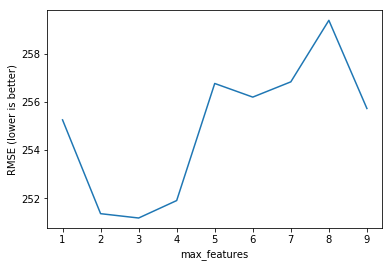

In [49]:
# Plot max_features (x-axis) versus RMSE (y-axis).
fig, ax = plt.subplots()
ax.plot(feature_range, RMSE_scores);
ax.set_xlabel('max_features');
ax.set_ylabel('RMSE (lower is better)');

In [52]:
feature_cols = ['Score_Net', 'Loss', 'Overtime', 'Loss_n-1', 'Record_Net', 'Streak_Clean', 'Elo', 'Start_Time']

X = Plays_By_Game.loc[:, feature_cols]
y = Plays_By_Game.loc[:, 'Video_Plays_Total_y']

rfreg_4 = RandomForestRegressor(n_estimators=150, max_features=3, oob_score=True)

rfreg_4.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=None, oob_score=True,
           random_state=None, verbose=0, warm_start=False)

In [53]:
pd.DataFrame(
    {'feature': feature_cols, 'importance': rfreg_4.feature_importances_}
).sort_values('importance', ascending=False)

,feature,importance
0,Score_Net,0.273678
4,Record_Net,0.187922
5,Streak_Clean,0.175164
1,Loss,0.165888
6,Elo,0.120586
7,Start_Time,0.042218
3,Loss_n-1,0.023089
2,Overtime,0.011456


In [54]:
rfreg_4.oob_score_

0.5035950930647628

In [55]:
kf = KFold(n_splits=10, shuffle=True)

scores = -cross_val_score(rfreg_4, X, y, cv=kf, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(scores)
rmse = np.mean(rmse_scores)
rmse

257.68571403693176

We've gotten to a good place with the data we have, but it would make sense to make two improvements going forward:
1. I'd like to go back to the analysis by video and determine if tainted features can be corrected and added back. I'd love to answer the question: if we are going to edit video tonight, what kind of videos are most likely to be viewed?
2. I'd like to add last year's data to the "per game" analysis. This data from last year was structured differently and will require additional clean-up, but less than on the granular video-by-video analysis.